**Навигация по уроку**
1. [Семантическая сегментация изображений](https://colab.research.google.com/drive/10Zl8P7-YLFr9kXdjnvUuXDkruFBSFrlc)
2. [Практическая реализация модели сегментации](https://colab.research.google.com/drive/1yFPXLtKKTQcnOAy6JO3FYHdTbOAGtprR)
3. [Мультиклассовая сегментация](https://colab.research.google.com/drive/1Fy26vjAZPOVTOh8ZLnUYHiev3jD7J4Sh)
4. Домашняя работа

В домашней работе вам необходимо выполнить одно из трёх заданий на выбор:


**Задание 1. На 3 балла:**

1. Ваша задача используя модель и датасет из третей части урока, самостоятельно познакомиться с библиотекой [Albumentations](https://albumentations.ai/) и применить несколько методов аугментации для семантической сегментации снимков с беспилотника.

2. Используйте коллбэк функцию для предварительной остановки процесса обучения. Подумайте: какие параметры для остановки вы применили и почему?


**Задание 2. На 4 балла:**

1. Ваша задача зарегистрироваться на платформе по проведению соревнований в сфере машинного обучения [kaggle](https://www.kaggle.com/).
2. Загрузить датасет с данными о радиографическом ислледовании по COVID-19:

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  alexandrtern


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:00<00:00, 1.01GB/s]


3. Обучить U-net подобную архитектуру сегментировать легкие человека на радиографическом снимке. Используйте данные о нормальном состоянии легких в папке `covid19-radiography-database/COVID-19_Radiography_Dataset/Normal`.

4. Отобразите по 10 снимков с оригинальным изображением, оригинальной маской и предсказанной маской.

**Задание 3. На 5 балла:**

1. Самостоятельно изучите модель [U-net++](https://arxiv.org/pdf/1807.10165.pdf). Найдите ее архитектуру, в интернете множество статей с готовой архитектурой на TensorFlow и Keras.
2. Выполните задание 2 для датасета с нормальным состоянием легких используя модель U-net++.


# Загрузка датасета

Для загрузки датасета в корневой папке нутбука должен лежать файл kaggle.json, который создается в разделе API профиля на kaggle.

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  alexandrtern


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:00<00:00, 1.23GB/s]


In [ ]:
!apt-get install -qq tree

Selecting previously unselected package tree.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!tree /content/covid19-radiography-database -d -L 5

/content/covid19-radiography-database
└── COVID-19_Radiography_Dataset
    ├── COVID
    │   ├── images
    │   └── masks
    ├── Lung_Opacity
    │   ├── images
    │   └── masks
    ├── Normal
    │   ├── images
    │   └── masks
    └── Viral Pneumonia
        ├── images
        └── masks

13 directories


# Импорты

In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.metrics import BinaryIoU
from keras.optimizers.schedules import PolynomialDecay

from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline



2025-08-10 15:38:48.200999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754840328.397904      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754840328.458583      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Проверяем изображение

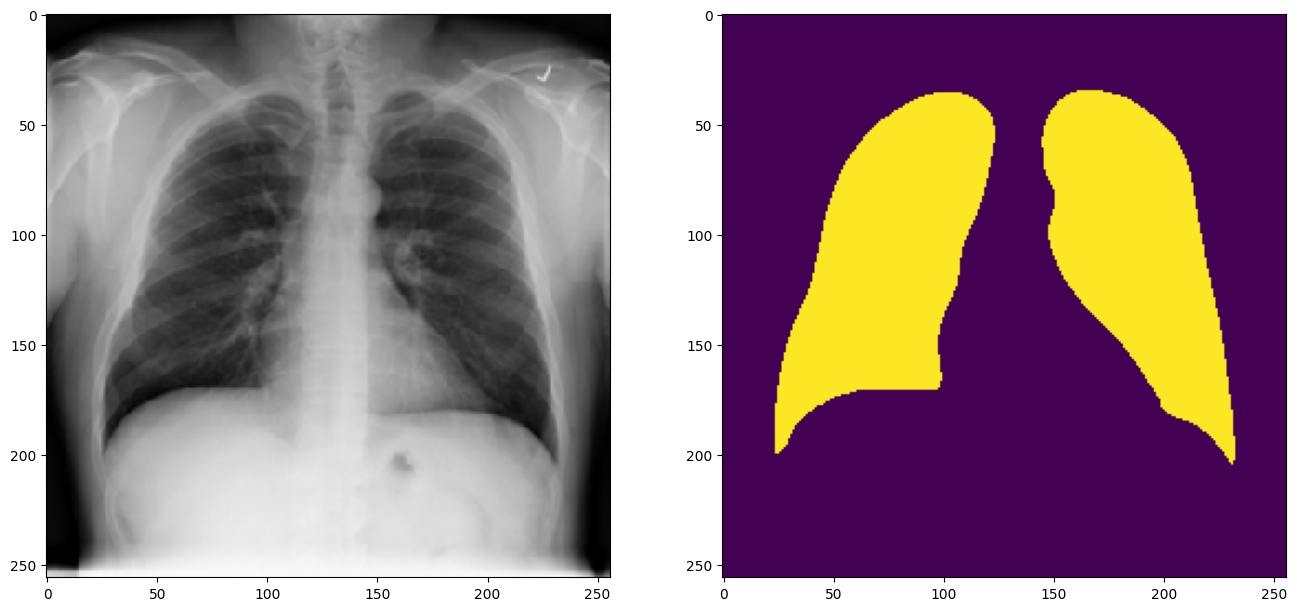

In [ ]:
original_image =  './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10.png'      # путь до ориганального изображения
label_image_semantic = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-10.png' # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

In [ ]:
print('Изображений всего: ', len(os.listdir('./covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/')))
print('Масок всего: ', len(os.listdir('./covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/')))

Изображений всего:  10192
Масок всего:  10192


# Создаем наборы изображений

In [ ]:
dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/'
image_dir = 'images'
label_dir = 'masks'

img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")
    ]
)

mask_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")
    ]
)

# Клсс генератора

In [ ]:
NUM_CLASSES = 2 # легкие и фон
batch_size = 8
img_size = (256, 256)

# Генератор для перебора данных (в виде массивов Numpy)

class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.num_classes = num_classes
        self.validation = validation
        self.indexes = np.arange(len(input_img_path))
        self.on_epoch_end()


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size

    def on_epoch_end(self):
        if not self.validation:
            np.random.shuffle(self.indexes)


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Вычисляем индексы для текущего батча
        batch_indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Получаем пути к изображениям и маскам для выбранных индексов
        batch_input_img_path = [self.input_img_path[i] for i in batch_indexes]
        batch_target_img_path = [self.target_img_path[i] for i in batch_indexes]

        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")
        y = np.zeros((self.batch_size, *self.img_size, 1), dtype="float32")  # 1 канал!

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for i in range(self.batch_size):  # Проходим по индексам от 0 до batch_size-1
            img = np.array(load_img(batch_input_img_path[i], target_size=self.img_size, color_mode='rgb'))
            mask = np.array(load_img(batch_target_img_path[i], target_size=self.img_size, color_mode='grayscale'))

            mask = (mask > 127).astype(np.float32)


            # Применяем аугментацию для обучающей выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
            transform = A.Compose([ # определяем функцию аугментации
                            A.D4(p=0.57), # симметричные трансформации* с вероятностью 57%
                            A.RandomBrightnessContrast(p=0.5),
                            A.GridDistortion(p=0.2),
                            A.GaussNoise(p=0.3)
                            ])
            transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
            img = transformed["image"]
            mask = transformed["mask"]

            x[i] = img / 255 # нормализуем изображение

            y[i] = np.expand_dims(mask, axis=-1)  # Добавляем размерность канала

        return x, y


D4 в аугментации означает применение одного из следующих эффектов, согласно документации Albumentations:

The square symmetry transformations include:
- Identity: No transformation is applied
- 90° rotation: Rotate 90 degrees counterclockwise
- 180° rotation: Rotate 180 degrees
- 270° rotation: Rotate 270 degrees counterclockwise
- Vertical flip: Mirror across vertical axis
- Anti-diagonal flip: Mirror across anti-diagonal
- Horizontal flip: Mirror across horizontal axis
- Main diagonal flip: Mirror across main diagonal

В наборе так же есть преобразовение Identity: No transformation is applied, которое означает, что даже если аугментация сработает и выпадет Identity, то изображение останется таким же. В случае, если мы ходим распределение примерно поровноу между аугментированными и не аугментированными изображениями, то нам нужна вероятность срабатывания аугментации 57.1%

# Перемешаем и разделим наборы

In [ ]:
from sklearn.model_selection import train_test_split

# Разделяем с сохранением соответствия между изображениями и масками
train_img_path, val_img_path, train_mask_path, val_mask_path = train_test_split(
    img_path,
    mask_path,
    test_size=0.2,
    random_state=42  # для воспроизводимости
)

In [ ]:
# создаем экземпляры генератоа
train_gen = datasetGenerator(batch_size, img_size, train_img_path, train_mask_path, num_classes = NUM_CLASSES)

val_gen = datasetGenerator(batch_size, img_size, val_img_path, val_mask_path, num_classes = NUM_CLASSES)

In [ ]:
len(train_gen)

1019

In [ ]:
len(val_gen)

254

Проверим вывод генератора

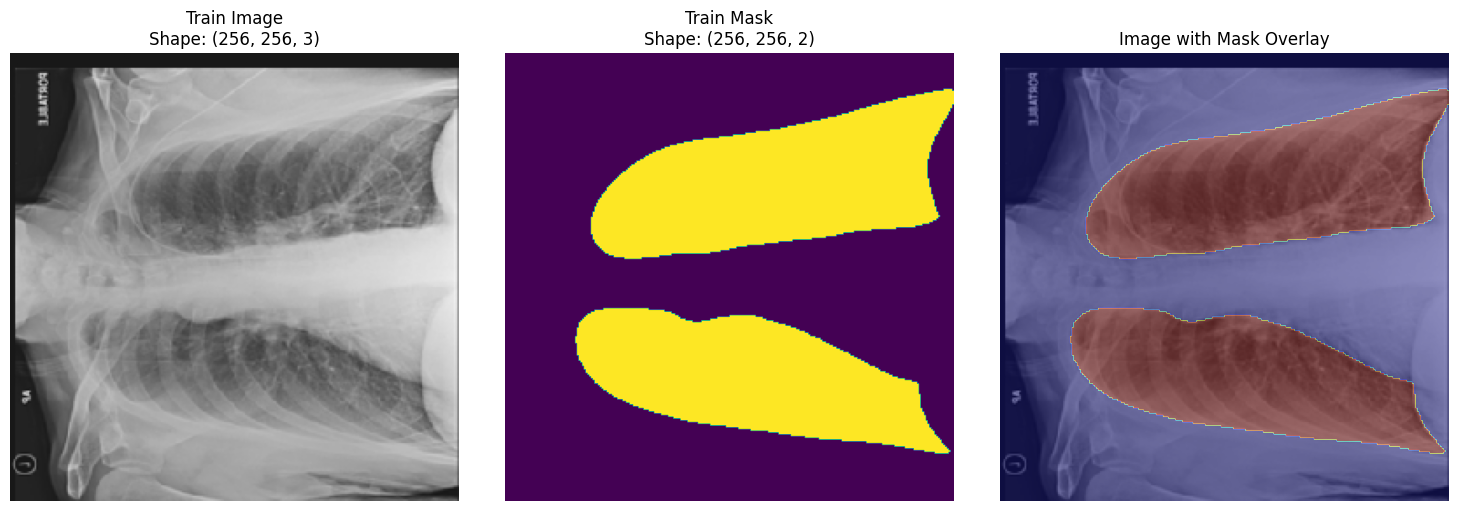

Image value range: [0.09, 0.94]
Mask unique values: [0 1]
Mask class distribution: [42357 23179]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_random_sample(generator):
    """Визуализирует случайный образец из генератора"""
    # Получаем случайный батч
    batch_idx = np.random.randint(0, len(generator))
    images, masks = generator[batch_idx]

    # Выбираем случайный образец из батча
    sample_idx = np.random.randint(0, images.shape[0])
    image = images[sample_idx]
    mask = masks[sample_idx]

    # Преобразуем маску для визуализации
    if mask.shape[-1] == 1:
        # Одноканальная маска
        mask_vis = mask.squeeze()
    else:
        # Для one-hot масок: берем argmax по каналам
        mask_vis = np.argmax(mask, axis=-1)

    # Создаем визуализацию
    plt.figure(figsize=(15, 5))

    # Изображение
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Train Image\nShape: {image.shape}")
    plt.axis('off')

    # Маска
    plt.subplot(1, 3, 2)
    plt.imshow(mask_vis, cmap='viridis')
    plt.title(f"Train Mask\nShape: {mask.shape}")
    plt.axis('off')

    # Наложение маски на изображение
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask_vis, alpha=0.4, cmap='jet')  # alpha - прозрачность
    plt.title("Image with Mask Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Дополнительная информация
    print(f"Image value range: [{np.min(image):.2f}, {np.max(image):.2f}]")
    print(f"Mask unique values: {np.unique(mask_vis)}")
    print(f"Mask class distribution: {np.bincount(mask_vis.flatten())}")

# Использование функции
visualize_random_sample(train_gen)

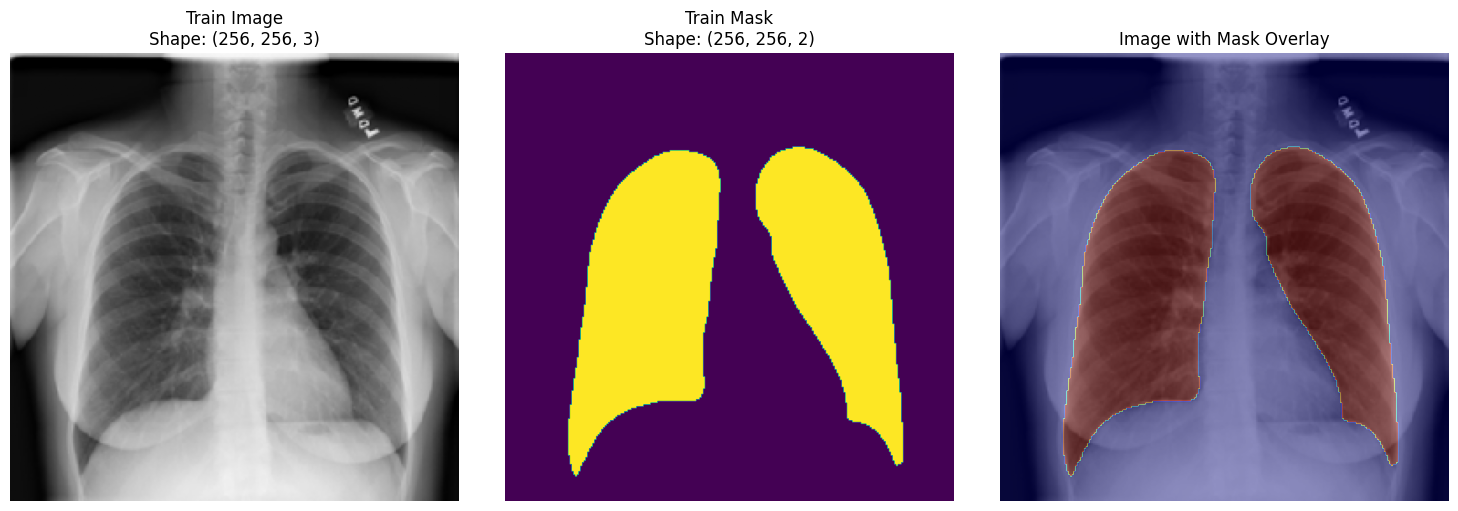

Image value range: [0.00, 0.98]
Mask unique values: [0 1]
Mask class distribution: [47225 18311]


In [ ]:
visualize_random_sample(val_gen)

In [ ]:
def calculate_class_distribution(generator, num_classes=2):
    total_counts = np.zeros(num_classes)

    for i in range(len(generator)):
        _, masks = generator[i]

        # Для one-hot масок
        if masks.shape[-1] > 1:
            class_indices = np.argmax(masks, axis=-1)
        else:
            class_indices = masks.squeeze()

        counts = np.bincount(class_indices.flatten(), minlength=num_classes)
        total_counts += counts

    return total_counts / np.sum(total_counts)

# Вызов функции
class_distribution = calculate_class_distribution(train_gen)
print(f"Общее распределение классов: {class_distribution}")

Общее распределение классов: [0.74791853 0.25208147]


In [ ]:
# Использование tf.data.Dataset с оптимизациями
def create_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 256, 256, 3)),
            tf.TensorSpec(shape=(None, 256, 256, 1))
        )
    )
    return dataset.prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_gen)
val_ds = create_dataset(val_gen)

I0000 00:00:1754840366.009458      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754840366.010139      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Архитектура модели U-net++

In [ ]:
# Основной строительный блок свертки
def conv_block(input_tensor, filters, kernel_size=(3, 3)):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
def build_model(input_shape=(256, 256, 3), num_classes=2, filters=64, depth=4):
    """Строит модель U-Net++ с заданной глубиной"""
    inputs = Input(input_shape)

    # Словарь для хранения узлов сети: {(i, j): tensor}
    nodes = {}

    # --- Путь вниз (encoder) ---
    for i in range(depth + 1):
        if i == 0:
            # Первый блок без пулинга
            x = conv_block(inputs, filters * (2**i))
            nodes[(i, 0)] = x
        else:
            # Пулинг + конволюционный блок
            x = MaxPooling2D((2, 2))(nodes[(i-1, 0)])
            x = conv_block(x, filters * (2**i))
            nodes[(i, 0)] = x

    # --- Плотные соединения (dense connections) ---
    for j in range(1, depth + 1):
        for i in range(0, depth - j + 1):
            # Собираем входы для текущего узла
            skip_connections = []

            # Узел слева (на том же уровне)
            if j > 0:
                skip_connections.append(nodes[(i, j-1)])

            # Узлы снизу (с более глубоких уровней)
            for k in range(1, j + 1):
                # Апсэмплинг узла с уровня i+k
                up_node = Conv2DTranspose(
                    filters * (2**i),
                    kernel_size=(2, 2),
                    strides=(2**k, 2**k),
                    padding='same'
                )(nodes[(i+k, j-k)])
                skip_connections.append(up_node)

            # Конкатенация всех входов
            concat = Concatenate()(skip_connections)

            # Конволюционный блок
            x = conv_block(concat, filters * (2**i))
            nodes[(i, j)] = x

    # --- Выходной слой ---
    # Используем последний узел первого уровня (0, depth)
    output_node = nodes[(0, depth)]
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(output_node)

    return Model(inputs, outputs)

In [ ]:
# функция потерь
def dice_loss(y_true, y_pred, smooth=1e-6):
    total_loss = 0
    num_classes = y_pred.shape[-1]

    for class_idx in range(num_classes):
        y_true_c = y_true[..., class_idx]
        y_pred_c = y_pred[..., class_idx]

        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)

        class_loss = 1 - (2. * intersection + smooth) / (union + smooth)
        total_loss += class_loss

    return total_loss / num_classes  # усреднение по классам

In [ ]:
# Параметры обучения
TOTAL_SAMPLES = len(os.listdir('./covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/'))
BATCH_SIZE = batch_size
EPOCHS = 10
VALIDATION_SPLIT = 0.2

# Рассчет шагов
train_steps = len(train_gen)
val_steps = len(val_gen)
total_steps = EPOCHS * train_steps

In [ ]:
# Планировщик learning rate
lr_schedule = PolynomialDecay(
    initial_learning_rate=1e-3,
    decay_steps=total_steps,
    end_learning_rate=5e-4,
    power=1.0
)

In [ ]:
# Построение модели
# Создаем экземпляр оптимизатора
optimizer = Adam(learning_rate=1e-4)

model = build_model(input_shape=(256, 256, 3), num_classes=2)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        BinaryIoU(target_class_ids=[1], name='iou_obj'),
    ]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_60[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_61       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ activation_61[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_62       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_62[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ activation_63[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_66[0][0] 

 Total params: 39,006,209 (148.80 MB)

 Trainable params: 38,991,617 (148.74 MB)

 Non-trainable params: 14,592 (57.00 KB)

In [ ]:
# Колбэки
class PredictionPlotter(Callback):
    def __init__(self, validation_data, num_samples=1):
        super().__init__()
        self.validation_data = validation_data
        self.num_samples = num_samples

        # Получаем фиксированные примеры
        self.sample_images, self.sample_masks = self._get_samples()

    def _get_samples(self):
        # Для tf.data.Dataset
        for batch in self.validation_data.take(1):
            images, masks = batch
            return images[:self.num_samples], masks[:self.num_samples]

    def on_epoch_end(self, epoch, logs=None):
        # Предсказание
        pred_masks = self.model.predict(self.sample_images, verbose=0)

        # Создаем новую фигуру для каждой эпохи
        plt.figure(figsize=(20, 5))

        for i in range(self.num_samples):
            # 1. Исходное изображение
            plt.subplot(1, 4, 1)
            plt.imshow(self.sample_images[i].numpy())
            plt.title("Input Image")
            plt.axis('off')

            # 2. Истинная маска
            plt.subplot(1, 4, 2)
            true_mask = self.sample_masks[i].numpy()[..., 1]
            plt.imshow(true_mask, cmap='gray')
            plt.title("True Mask")
            plt.axis('off')

            # 3. Предсказанная маска
            plt.subplot(1, 4, 3)
            pred_mask = pred_masks[i][..., 1]
            plt.imshow(pred_mask, cmap='gray')
            plt.title(f"Predicted (Epoch {epoch+1})")
            plt.axis('off')

            # 4. Наложение
            plt.subplot(1, 4, 4)
            plt.imshow(self.sample_images[i].numpy())
            plt.imshow(np.where(pred_mask > 0.5, 1, 0), alpha=0.4, cmap='jet')
            plt.title("Overlay")
            plt.axis('off')

        # Отображаем в ноутбуке
        plt.tight_layout()
        plt.show()

# Использование в обучении
# Сначала подготовим фиксированные примеры из валидационного набора
val_sample = next(iter(val_ds))  # Берем один батч

# Создаем callback
plot_callback = PredictionPlotter(
    validation_data=val_ds,
    num_samples=1
)



In [ ]:
class GradientMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Проверяем изменения весов как индикатор обучения
        weights = self.model.get_weights()
        if epoch == 0:
            self.prev_weights = weights
            return

        weight_changes = [np.mean(np.abs(w - w_prev))
                         for w, w_prev in zip(weights, self.prev_weights)]
        mean_change = np.mean(weight_changes)
        print(f"Epoch {epoch} | Mean weight change: {mean_change:.2e}")
        self.prev_weights = weights

In [ ]:
callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_iou_obj',
        save_best_only=True,
        mode='max'
    )
]

## Обучение

In [ ]:
# IoU если всегда предсказывать фон
def baseline_iou(generator):
    ious = []
    for i in range(len(generator)):
        _, y_true = generator[i]
        # Предсказываем все как фон (класс 0)
        y_pred = np.zeros_like(y_true)
        iou = BinaryIoU(target_class_ids=[1])(y_true, y_pred).numpy()
        ious.append(iou)
    return np.mean(ious)

print(f"Baseline IoU (always background): {baseline_iou(val_gen):.4f}")

Baseline IoU (always background): 0.0000


In [ ]:
# Проверка генератора
sample_x, sample_y = train_gen[0]
print("Input shape:", sample_x.shape)  # Ожидается (8, 256, 256, 3)
print("Target shape:", sample_y.shape) # Ожидается (8, 256, 256, 1)

# Проверка модели
dummy_input = np.zeros((1, 256, 256, 3))
pred = model.predict(dummy_input)
print("Output shape:", pred.shape)     # Ожидается (1, 256, 256, 1)

Input shape: (8, 256, 256, 3)
Target shape: (8, 256, 256, 1)


I0000 00:00:1754840400.454988     112 service.cc:148] XLA service 0x7bcbdc003750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754840400.455484     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754840400.455504     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754840400.840561     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754840410.692596     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


KeyboardInterrupt: 

In [ ]:
# Обучение модели
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 1574s 1s/step - iou_obj: 0.7431 - loss: 0.2213 - val_iou_obj: 0.9450 - val_loss: 0.0496
Epoch 2/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 122s 120ms/step - iou_obj: 0.0000e+00 - loss: 0.0000e+00 - val_iou_obj: 0.9453 - val_loss: 0.0495
Epoch 3/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 1515s 1s/step - iou_obj: 0.9505 - loss: 0.0413 - val_iou_obj: 0.9547 - val_loss: 0.0338
Epoch 4/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 120s 118ms/step - iou_obj: 0.0000e+00 - loss: 0.0000e+00 - val_iou_obj: 0.9528 - val_loss: 0.0349
Epoch 5/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 1513s 1s/step - iou_obj: 0.9572 - loss: 0.0311 - val_iou_obj: 0.9539 - val_loss: 0.0347
Epoch 6/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 123s 120ms/step - iou_obj: 0.0000e+00 - loss: 0.0000e+00 - val_iou_obj: 0.9548 - val_loss: 0.0345
Epoch 7/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 1518s 1s/step - iou_obj: 0.9614 - loss: 0.0265 - val_iou_obj: 0.9628 - val_loss: 0.0263
Epoch 8/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 119s 117ms/step - 

# Визуализация

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


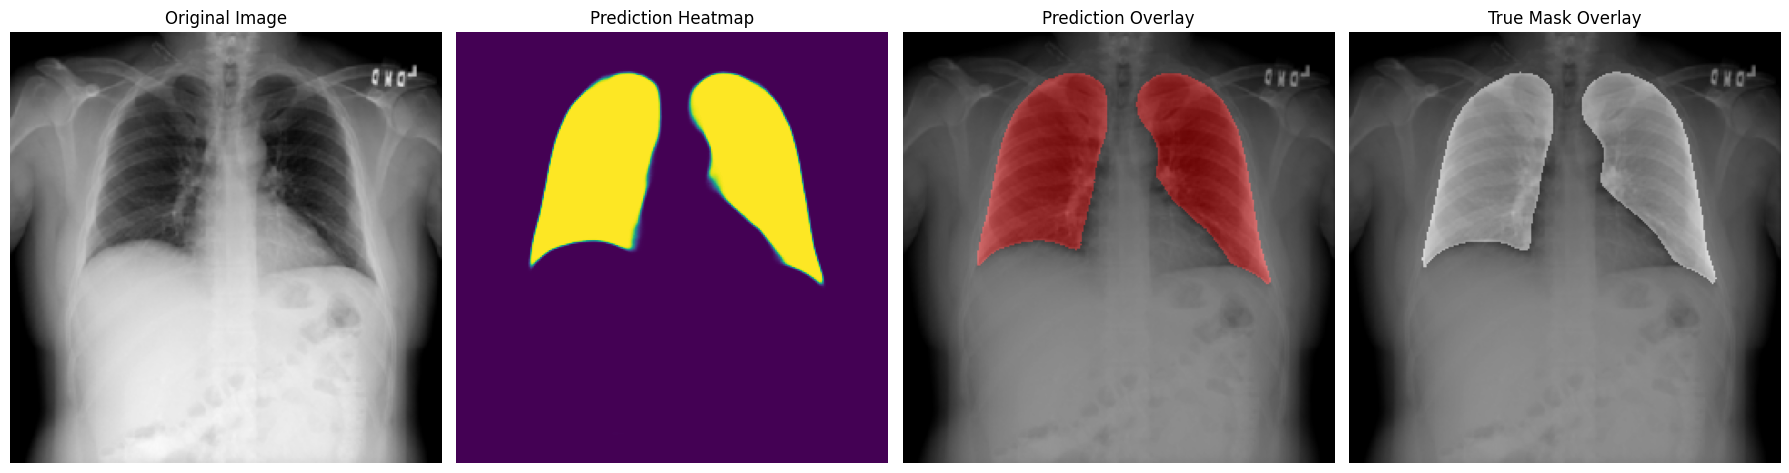

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def visualize_prediction(model, image_path, mask_path=None, alpha=0.4, threshold=0.5):
    """
    Визуализирует предсказание модели на изображении с возможным наложением истинной маски
    """
    # Загрузка и предобработка изображения
    img = np.array(load_img(image_path, target_size=(256, 256, 3)), dtype=np.float32)
    img_normalized = img / 255.0

    # Получение предсказания
    pred = model.predict(np.expand_dims(img_normalized, axis=0))[0]

    # Бинаризация предсказания
    pred_binary = (pred > threshold).astype(np.float32)

    # Создание цветной маски
    cmap = mcolors.LinearSegmentedColormap.from_list('lung_cmap', ['black', 'red'])
    pred_colored = cmap(pred_binary.squeeze())[..., :3]

    # Визуализация
    plt.figure(figsize=(18, 12))

    # 1. Оригинальное изображение
    plt.subplot(1, 3 + int(mask_path is not None), 1)
    plt.imshow(img.astype(np.uint8))
    plt.title("Original Image")
    plt.axis('off')

    # 2. Предсказание модели
    plt.subplot(1, 3 + int(mask_path is not None), 2)
    plt.imshow(pred.squeeze(), cmap='viridis')
    plt.title("Prediction Heatmap")
    plt.axis('off')

    # 3. Наложение предсказания
    plt.subplot(1, 3 + int(mask_path is not None), 3)
    plt.imshow(img.astype(np.uint8))
    plt.imshow(pred_colored, alpha=alpha)
    plt.title("Prediction Overlay")
    plt.axis('off')

    # 4. Если есть истинная маска
    if mask_path:
        true_mask = np.array(load_img(mask_path, target_size=(256, 256, 1)), dtype=np.float32)
        true_mask = (true_mask > 127).astype(np.float32)

        # Сравнение с истиной
        plt.subplot(1, 4, 4)
        plt.imshow(img.astype(np.uint8))
        plt.imshow(true_mask.squeeze(), alpha=alpha, cmap='jet')
        plt.title("True Mask Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Cлучайное изображение из валидационного набора
sample_idx = np.random.randint(len(val_img_path))
image_path = val_img_path[sample_idx]
mask_path = val_mask_path[sample_idx]

# Визуализация
visualize_prediction(model, image_path, mask_path)

# Итог

Мы обучили модель U-net++ с 4 уровнями предсказывать сегменты на изображениях нормальных легких, точность оценивалась с помощью метрики IoU. В нашем случае из за небольшого размера изображения 256*256 а так же крупной доли легких на изображении и присутствия всего 2 классов для сегментации мы получили очень высокие показатели предикта. В обучении заметна проблема четных эпох - это связано с функцией перемешивания в генераторе, что в целом не помешало нашей модели закончить обучение. Так же в связи с проблемой при обучении с Dice-loss на эпохах после первой идет глубокое падение показателей,я отказался в пользу Binary-crossentropy.